In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

CONTRACTION_MAP = {
    "don't": "do not", "can't": "cannot", "won't": "will not",
    "it's": "it is", "i'm": "i am", "you're": "you are",
    "i've": "i have", "they're": "they are", "we're": "we are",
    "didn't": "did not", "hadn't": "had not", "wouldn't": "would not"
}

def expand_contractions(text):
    for contraction, expansion in CONTRACTION_MAP.items():
        text = re.sub(r'\b{}\b'.format(contraction), expansion, text, flags=re.IGNORECASE)
    return text

def advanced_preprocess_text(text):
    text = expand_contractions(text)
    text = text.lower()
    text = re.sub(r'\S*\d\S*', '', text).strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [word for word in words if word not in stop_words and word.strip() != '']
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

try:
    df = pd.read_csv(r'C:\Users\Jean\Downloads\complaints.csv', encoding='latin-1')
except FileNotFoundError:
    print("Error: Dataset file not found")
    exit()

target_categories = [
    'Credit reporting, repair, or other', 'Debt collection',
    'Consumer Loan', 'Mortgage'
]
category_map = {name: i for i, name in enumerate(target_categories)}

df_filtered = df[df['Product'].isin(target_categories)].copy()
df_filtered['Category_ID'] = df_filtered['Product'].map(category_map)

df_filtered.dropna(subset=['Consumer complaint narrative', 'Category_ID'], inplace=True)
df_filtered = df_filtered[df_filtered['Consumer complaint narrative'] != 'N/A']

print(f"Total relevant complaints: {len(df_filtered)}")

Total relevant complaints: 515927


In [5]:
df_filtered['Clean_Narrative'] = df_filtered['Consumer complaint narrative'].apply(advanced_preprocess_text)

X = df_filtered['Clean_Narrative']
y = df_filtered['Category_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [10]:
from sklearn.svm import LinearSVC
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear', multi_class='auto', max_iter=1000),
    'Linear SVM': LinearSVC(random_state=42, dual=False)
}

results = {}

print("\n--- Model Training and Comparison (3 Models) ---")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = {'accuracy': accuracy, 'model': model}
    print(f"  {name} Accuracy: {accuracy:.4f}")

best_model_name = max(results, key=lambda name: results[name]['accuracy'])
best_model = results[best_model_name]['model']

print(f"\nBest Performing Model: {best_model_name}")


--- Model Training and Comparison (3 Models) ---
Training Multinomial Naive Bayes...
  Multinomial Naive Bayes Accuracy: 0.9440
Training Logistic Regression...


C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


  Logistic Regression Accuracy: 0.9696
Training Linear SVM...
  Linear SVM Accuracy: 0.9700

Best Performing Model: Linear SVM



--- Model Evaluation and Saving Confusion Matrices ---
 Classification Report for Multinomial Naive Bayes 
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.00      0.00      0.00         0
                   Debt collection       0.98      0.95      0.97     74326
                     Consumer Loan       0.61      0.35      0.44      1892
                          Mortgage       0.87      0.97      0.92     26968

                          accuracy                           0.94    103186
                         macro avg       0.61      0.57      0.58    103186
                      weighted avg       0.94      0.94      0.94    103186

Saved confusion matrix to confusion_matrix_multinomial_naive_bayes.png


C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[

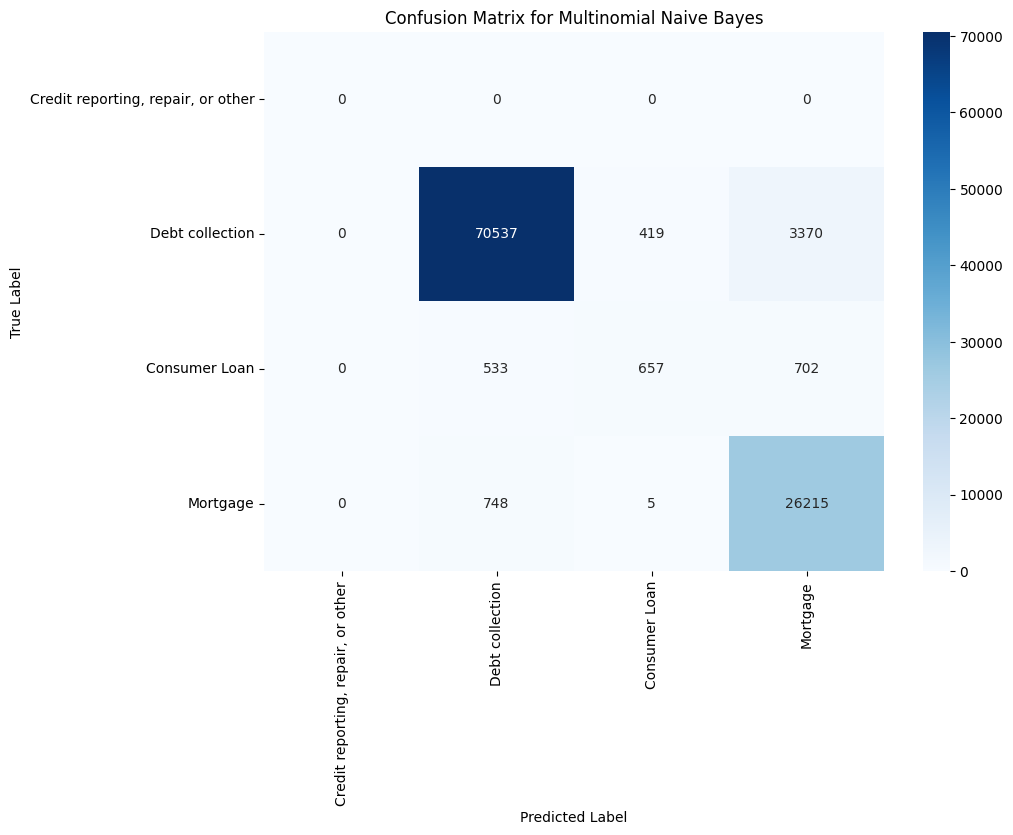

 Classification Report for Logistic Regression 
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.00      0.00      0.00         0
                   Debt collection       0.98      0.98      0.98     74326
                     Consumer Loan       0.80      0.45      0.58      1892
                          Mortgage       0.96      0.96      0.96     26968

                          accuracy                           0.97    103186
                         macro avg       0.68      0.60      0.63    103186
                      weighted avg       0.97      0.97      0.97    103186

Saved confusion matrix to confusion_matrix_logistic_regression.png


C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[

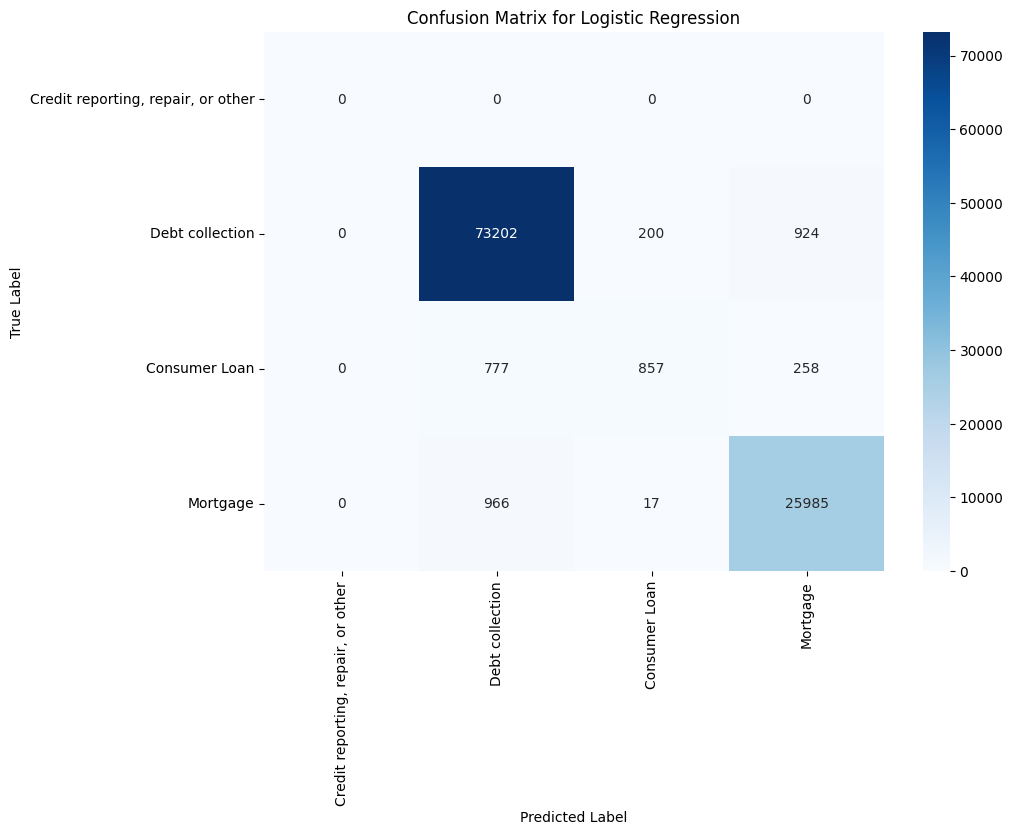

 Classification Report for Linear SVM 
                                    precision    recall  f1-score   support

Credit reporting, repair, or other       0.00      0.00      0.00         0
                   Debt collection       0.98      0.98      0.98     74326
                     Consumer Loan       0.77      0.50      0.61      1892
                          Mortgage       0.96      0.96      0.96     26968

                          accuracy                           0.97    103186
                         macro avg       0.68      0.61      0.64    103186
                      weighted avg       0.97      0.97      0.97    103186

Saved confusion matrix to confusion_matrix_linear_svm.png


C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Jean\anaconda3\envs\hd-bet\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[

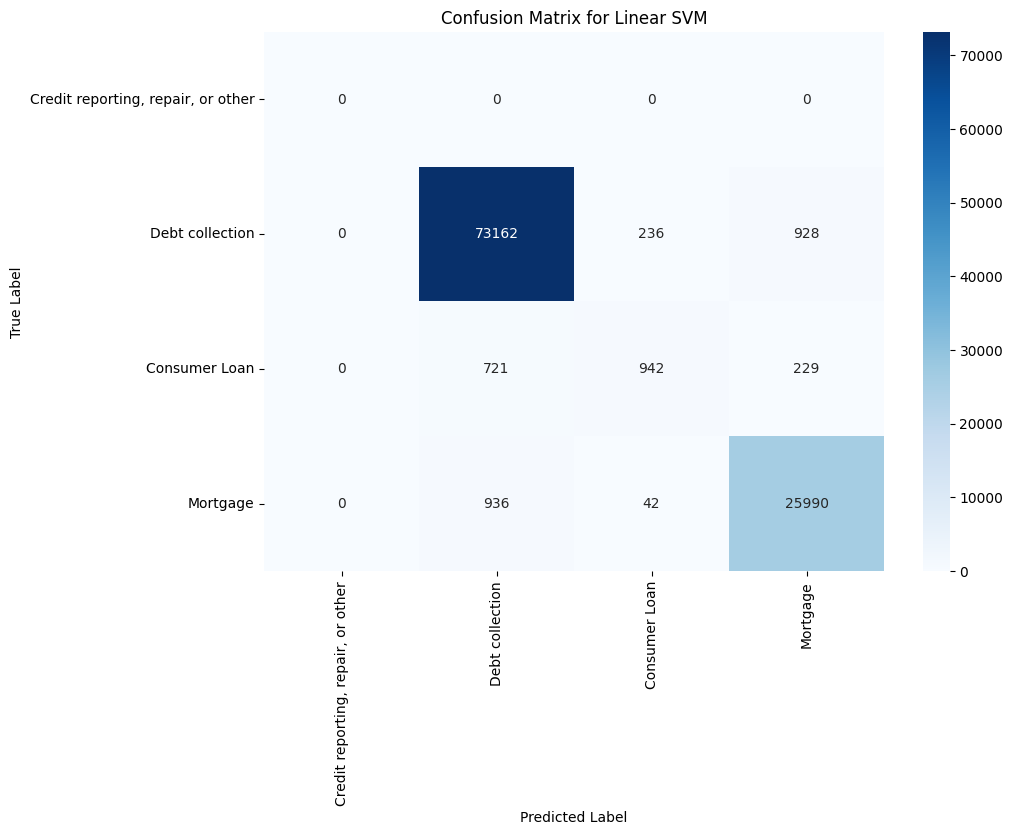

In [16]:

all_labels = list(range(len(target_categories)))

print("\n--- Model Evaluation and Saving Confusion Matrices ---")

for name, model_data in results.items():
    model = model_data['model']
    
    # 1. Classification Report (unchanged)
   
    print(f" Classification Report for {name} ")
  
    y_pred = model.predict(X_test_tfidf)
    
   
    print(classification_report(y_test, y_pred, target_names=target_categories, labels=all_labels))


    cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_categories, yticklabels=target_categories)
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
   
    filename = f"confusion_matrix_{name.replace(' ', '_').lower()}.png"
    plt.savefig(filename)
    print(f"Saved confusion matrix to {filename}")

    plt.show()

In [14]:
def classify_complaint(complaint_text, model, vectorizer, category_map):
    clean_text = advanced_preprocess_text(complaint_text)
    text_vector = vectorizer.transform([clean_text])
    predicted_id = model.predict(text_vector)[0]

    inv_category_map = {v: k for k, v in category_map.items()}
    return inv_category_map.get(predicted_id, "Unknown")

sample_complaint = "The debt collector keeps calling my phone even after I told them I was bankrupt. This has affected my credit score."
predicted_class = classify_complaint(sample_complaint, best_model, tfidf_vectorizer, category_map)

print(f"\n--- Final Prediction Example ---")
print(f"Sample Complaint: \"{sample_complaint}\"")
print(f"Predicted Category: {predicted_class}")


--- Final Prediction Example ---
Sample Complaint: "The debt collector keeps calling my phone even after I told them I was bankrupt. This has affected my credit score."
Predicted Category: Debt collection
